# Teste de Classificadores com ajuste de peso e modelos de arvore com up/downsampling 

O objetivo é testar os modelos XGBoost e adaBoost sem sampling e a floresta aleatoria e arvore de decisão com sampling, analisar qual deles tem a melhor metrica de recall para o banco de dados com todas as 4 tabelas e qual tem o melhor ponto de cotovelo na curva recall-precision.

## Preparar os dados e criar classe de processamento 

### Importando bibliotecas e dados

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice

from tqdm.auto import tqdm
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords

from transformers import TrainingArguments, Trainer, AutoTokenizer,BertForSequenceClassification,pipeline
import torch
from torch.utils.data import TensorDataset, DataLoader
from datasets import load_dataset
import evaluate
from accelerate import Accelerator

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import sklearn.metrics as metrics
from sklearn.decomposition import TruncatedSVD
from enelvo.normaliser import Normaliser
import pickle
import os 

In [55]:
df_denuncia_crime=pd.read_csv('/Users/mhctds/Cidade_Social/base de dados/base_apps_denuncia_crime.csv')
df_base_rocinha=pd.read_csv('/Users/mhctds/Cidade_Social/base de dados/base_rocinha_df.csv')
df_protestos_2013=pd.read_csv('/Users/mhctds/Cidade_Social/base de dados/protestos_2013_df.csv')
df_protestos_PMES=pd.read_csv('/Users/mhctds/Cidade_Social/base de dados/protestos_PMES.csv')

### Criar classe de processamento

In [56]:
class DataProcessing:
    vect=None
    def import_vect(self,vectorizer):
        self.vect=vectorizer
    def export_vect(self):
        pickle.dump(self.vect, open("tfidf.pickle", "wb"))
        
    # Junta os dataframes dentro do vetor de dataframes
    def append_data(self,df_vector):
        df_final=df_vector[0]
        df_final=df_final[['text','Total(SUM)','Classe de Violência']]
        for df in islice(df_vector, 1, None) :
            df=df[['text','Total(SUM)','Classe de Violência']]
            df_final=pd.concat([df_final]+[df])
        df_final.reset_index()
        df_final['text']=df_final['text'].astype('str')
        return df_final
    
    #Normalização usando spacy
    def text_normalizer_spacy(self,corpus):
        nlp = spacy.load('pt_core_news_sm', disable=['parser', 'ner'])
        lemm=[]
        for text in tqdm(corpus):
            doc = nlp(text)
            #tokens = [token.lemma_ for token in doc if not token.is_stop]
            tokens = [token.lemma_ for token in doc]
            text= ' '.join(tokens)
            
            lemm.append(text)
        return lemm
    
    # Normalização usando enelvo e vetorização usando nltk 
    def text_preprocessing_nltk(self,corpus):
        stop_words=list(nltk_stopwords.words('portuguese'))
        norm = Normaliser(tokenizer='readable',sanitize=True)
        lemm=[]
        for texts in corpus:
            lemm.append(norm.normalise(texts))
        if self.vect is None:
            self.vect=TfidfVectorizer(stop_words=stop_words)
            self.vect.fit(corpus)
        processed=self.vect.transform(lemm)
        return processed
    
    #Vetorização usando nltk
    def text_preprocessing_nltk_no_norm(self,corpus):
        stop_words=list(nltk_stopwords.words('portuguese'))
        if self.vect is None:
            self.vect=TfidfVectorizer(stop_words=stop_words)
            self.vect.fit(corpus)
        processed=self.vect.transform(corpus)
        return processed
        
    #Mudar target para valor numerico
    def numerical_target(self,target):
        #Acts as a pointer, be careful 
        target.replace('Not Violence',0,inplace=True)
        target.replace('Low',1,inplace=True)
        target.replace('Medium',2,inplace=True)
        target.replace('High',3,inplace=True)
        target.replace('VeryHight',4,inplace=True)
        return target
    #fraction é a fração que vai sobrar do original, deve ser colocado um valor entre 0 e 1
    # Se usado 0.3 por exemplo, perderemos 60% dos registros daquele target, sobrando 30 porcento
    def downsample(self,features, target, fraction,value):
        features_true = features[target == value]
        features_false = features[target != value]
        target_true = target[target == value]
        target_false = target[target != value]

        features_downsampled = pd.concat(
            [features_true.sample(frac=fraction, random_state=12345)]
            + [features_false]
        )
        target_downsampled = pd.concat(
            [target_true.sample(frac=fraction, random_state=12345)]
            + [target_false]
        )

        return features_downsampled, target_downsampled
    # repeat é o numero de vezes que aquele target sera clonado, deve ser um int maior que 1
    def upsample(self,features, target, repeat,value):
        features_true = features[target == value]
        features_false = features[target != value]
        target_true = target[target == value]
        target_false = target[target != value]

        features_upsampled = pd.concat([features_false] + [features_true] * repeat)
        target_upsampled = pd.concat([target_false] + [target_true] * repeat)

        return features_upsampled, target_upsampled
    def division(self,df_final):
        df_final=df_final.drop_duplicates().reset_index()
        features=self.text_preprocessing_nltk(df_final['text'])
        target=df_final['Classe de Violência']
        train_data, test_data, train_target, test_target = train_test_split(features, target, test_size=0.3, random_state=12345,shuffle=True,stratify=target)
        
        class_size=[len(target[target=='Not Violence'])/len(target),len(target[target=='Low'])/len(target),len(target[target=='Medium'])/len(target),len(target[target=='High'])/len(target),len(target[target=='VeryHight'])/len(target)]
        class_name=['Not Violence','Low','Medium','High','VeryHight']
        print(target.unique())
        print(len(target[target=='Not Violence']))
        print(len(target[target=='Low']))
        print(len(target[target=='Medium']))
        print(len(target[target=='High']))
        print(len(target[target=='VeryHight']))
        print(len(target))
        
        plt.bar(class_name,class_size)
        plt.title('Distribution of classes in the dataset')
        plt.xlabel('Name of the class')
        plt.ylabel('Percentage of the class in the dataset')
        plt.figtext(.6, .8,"Size of the dataset is 1758 entries")
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
        
        return df_final,train_data, test_data, train_target, test_target
    
    def upsampled_division(self,df_final):
        df_sampled,garbage=train_test_split(df_final.drop_duplicates().reset_index(), test_size=0.3, random_state=12345,shuffle=True,stratify=df_final['Classe de Violência'])
        features_sampled,target_sampled=self.upsample(df_sampled['text'], df_sampled['Classe de Violência'], 240,'Low')
        features_sampled,target_sampled=self.upsample(features_sampled,target_sampled, 71,'Medium')
        features_sampled,target_sampled=self.upsample(features_sampled,target_sampled, 13,'High')
        features_sampled,target_sampled=self.upsample(features_sampled,target_sampled, 3,'VeryHigh')
        features_sampled=self.text_preprocessing_nltk(features_sampled)
        return features_sampled,target_sampled
    
    def convert_label(self,labels):
        new_labels=[]
        for label in labels:
            if label=='LABEL_0':
                new_labels.append(0)
            if label=='LABEL_3':
                new_labels.append(3)
            if label=='LABEL_4':
                new_labels.append(4)
        return new_labels
        
        
        
    
class MetricsProcessing:
    def probability(self,probability,test_target):
        target_proba=[]
        test_target=test_target.values
        for i in range(len(test_target)):
            if(test_target[i]=='High'):
                target_proba.append(probability[i,0])
            if(test_target[i]=='Low'):
                target_proba.append(probability[i,1])
            if(test_target[i]=='Medium'):
                target_proba.append(probability[i,2])
            if(test_target[i]=='Not Violence'):
                target_proba.append(probability[i,3])
            if(test_target[i]=='VeryHight'):
                target_proba.append(probability[i,4])
        return target_proba
    def probability_class(self,type_class,model,test_data):
        probability=model.predict_proba(test_data)
        #High:0, low:1, medium:2, not violence:3, VeryHigh:4
        return probability[:,type_class]
    def prediction_matriz_by_class(self,data):
        matriz=pd.DataFrame()
        classes=['High','Low','Medium','Not Violence','VeryHight']
        for column in classes:
            matriz[column]=np.where(data==column,1,0)
        return matriz
    def binary_goal(self,prediction,target):
        #safe
        vector=np.where(prediction==target,1,0)
        return vector
    def evaluate_model(self,model, train_features, train_target, test_features, test_target):
    
        eval_stats = {}
        
        fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
        
        for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
            
            eval_stats[type] = {}
        
            pred_target = model.predict(features)
            pred_proba =  model.predict_proba(features)
            test_matriz=self.prediction_matriz_by_class(data=target)

            # F1
            f1_thresholds = np.arange(0, 1.01, 0.05)
            f1_scores = [metrics.f1_score(self.binary_goal(pred_target,target), self.probability(pred_proba,target)>=threshold,average='micro') for threshold in f1_thresholds]
            
            #ROC over all micro-media
            fpr, tpr, roc_thresholds = metrics.roc_curve(test_matriz.values.ravel(), pred_proba.ravel())
            roc_auc = metrics.roc_auc_score(test_matriz.values.ravel(), pred_proba.ravel(),average='micro')
            eval_stats[type]['ROC AUC'] = roc_auc

            #Curva de precisão-revocação over all micro-media
            precision, recall, pr_thresholds = metrics.precision_recall_curve(test_matriz.values.ravel(), pred_proba.ravel())
            aps = metrics.average_precision_score(test_matriz.values.ravel(), pred_proba.ravel(),average='micro')
            eval_stats[type]['APS'] = aps
            
            
            if type == 'train':
                color = 'blue'
            else:
                color = 'green'

            # Valor F1
            ax = axs[0]
            max_f1_score_idx = np.argmax(f1_scores)
            ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
            # definindo cruzamentos para alguns limiares
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
                marker_color = 'orange' if threshold != 0.5 else 'red'
                ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.set_xlim([-0.02, 1.02])    
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('threshold')
            ax.set_ylabel('F1')
            ax.legend(loc='lower center')
            ax.set_title(f'Valor F1') 

            # ROC
            ax = axs[1]    
            ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
            # setting crosses for some thresholds
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
                marker_color = 'orange' if threshold != 0.5 else 'red'            
                ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
            ax.set_xlim([-0.02, 1.02])    
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('FPR')
            ax.set_ylabel('TPR')
            ax.legend(loc='lower center')        
            ax.set_title(f'Curva ROC Media')
            
            # Curva de precisão-revocação
            ax = axs[2]
            ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
            # definindo cruzamentos para alguns limiares
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
                marker_color = 'orange' if threshold != 0.5 else 'red'
                ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.set_xlim([-0.02, 1.02])    
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('recall')
            ax.set_ylabel('precision')
            ax.legend(loc='lower center')
            ax.set_title(f'PRC Media')        

            eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        
        df_eval_stats = pd.DataFrame(eval_stats)
        df_eval_stats = df_eval_stats.round(2)
        df_eval_stats = df_eval_stats.reindex(index=('Acurácia', 'F1', 'APS', 'ROC AUC'))
        
        print(df_eval_stats)
        
        return
    
    def pca_evaluator(model,model2,test_data,test_target,n_components):
        recall_list=[]
        components_list=[]
        for components in range (1,n_components):
            original=recall_score(test_target,model.predict(test_data),average='weighted')
            pca=TruncatedSVD(n_components=components,random_state=12345)
            new_data=pca.fit_transform(test_data)
            new_data=pca.inverse_transform(new_data)
            prediction=model.predict(new_data)
            recall_list.append(recall_score(test_target,prediction,average='weighted')/original)
            components_list.append(components)
        recall_list2=[]
        components_list2=[]
        for components in range (1,n_components):
            original=recall_score(test_target,model2.predict(test_data),average='weighted')
            pca=TruncatedSVD(n_components=components,random_state=12345)
            new_data=pca.fit_transform(test_data)
            new_data=pca.inverse_transform(new_data)
            prediction=model2.predict(new_data)
            recall_list2.append(recall_score(test_target,prediction,average='weighted')/original)
            components_list2.append(components)
        plt.xlabel('Number of dimensions')
        plt.ylabel('Percentage of the original recall')
        plt.plot(components_list, recall_list, color='blue', marker='X', markersize=7)
        plt.xlabel('Number of dimensions')
        plt.ylabel('Percentage of the original recall')
        plt.plot(components_list2, recall_list2, color='red', marker='X', markersize=7)
        return 
    
    def compute_metrics(p):    
        pred, labels = p
        pred = np.argmax(pred, axis=1)
        accuracy = accuracy_score(y_true=labels, y_pred=pred)
        recall = recall_score(y_true=labels, y_pred=pred,average='weighted')
        precision = precision_score(y_true=labels, y_pred=pred,average='weighted')
        f1 = f1_score(y_true=labels, y_pred=pred,average='weighted')    
        return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [73]:
class ModelProcessing:
    def dummy_model(data,target):
        kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
        model=DummyClassifier(strategy="most_frequent")
        scoring = ['accuracy','precision_weighted', 'recall_weighted','f1_weighted']
        scores = cross_validate(model, data, target,cv=kf, scoring=scoring)
        score_values=[score.mean() for score in scores.values()]
        print(sorted(scores.keys()))
        print([score.mean() for score in scores.values()])
        print('best recall:',score_values[4])
        print('best accuracy:',score_values[2])
        print('best f1:',score_values[5])
        print('best precision:',score_values[3])
        return model
    def adaboost_model(data,target):
        kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
        best_score_values=[0,0,0,0,0,0]
        #Talvez não tenha parametro  ou random_state
        #Talvez tenha parametro learning rate, talvez vale a pena testar
        for estimators in tqdm(range(1,100)):
            model = AdaBoostClassifier(n_estimators=estimators, random_state=12345)
            scoring = ['accuracy','precision_weighted', 'recall_weighted','f1_weighted']
            scores = cross_validate(model, data, target,cv=kf, scoring=scoring)
            scores_values=[score.mean() for score in scores.values()]
            if best_score_values[4]<scores_values[4]:
                best_model=model
                best_estimators=estimators
                best_score=scores
                best_score_values=scores_values
        print('best number of estimators:',best_estimators)
        print('best recall:',best_score_values[4])
        print('best accuracy:',best_score_values[2])
        print('best f1:',best_score_values[5])
        print('best precision:',best_score_values[3])
        return best_model
    def florest_model(data,target):
        kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
        best_score_values=[0,0,0,0,0,0]
        for size in tqdm(range(1,50)):
            for depth in range(1,30):
                model=RandomForestClassifier(random_state=123456789,max_depth=depth,n_estimators=size)
                scoring = ['accuracy','precision_weighted', 'recall_weighted','f1_weighted']
                scores = cross_validate(model, data, target,cv=kf, scoring=scoring)
                scores_values=[score.mean() for score in scores.values()]
                if best_score_values[4]<scores_values[4]:
                    best_model=model
                    best_size=size
                    best_depth=depth
                    best_score=scores
                    best_score_values=scores_values
        print('best depth:',best_depth)
        print('best size:',best_size)
        print('best recall:',best_score_values[4])
        print('best accuracy:',best_score_values[2])
        print('best f1:',best_score_values[5])
        print('best precision:',best_score_values[3])
        return best_model
    def tree_model(data,target):
        kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
        best_score_values=[0,0,0,0,0,0]
        for depth in tqdm(range(1,100)):
            model=DecisionTreeClassifier(random_state=123456789,max_depth=depth)
            scoring = ['accuracy','precision_weighted', 'recall_weighted','f1_weighted']
            scores = cross_validate(model, data, target,cv=kf, scoring=scoring)
            scores_values=[score.mean() for score in scores.values()]
            if best_score_values[4]<scores_values[4]:
                best_model=model
                best_depth=depth
                best_score=scores
                best_score_values=scores_values
        print('best depth:',best_depth)
        print('best recall:',best_score_values[4])
        print('best accuracy:',best_score_values[2])
        print('best f1:',best_score_values[5])
        print('best precision:',best_score_values[3])
        return best_model
    def naivebayes_model(data,target):
        kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
        model = GaussianNB()
        scoring = ['accuracy','precision_weighted', 'recall_weighted','f1_weighted']
        scores = cross_validate(model, data, target,cv=kf, scoring=scoring)
        score_values=[score.mean() for score in scores.values()]
        print(sorted(scores.keys()))
        print([score.mean() for score in scores.values()])
        print('best recall:',score_values[4])
        print('best accuracy:',score_values[2])
        print('best f1:',score_values[5])
        print('best precision:',score_values[3])
        return model

In [58]:
class BertProcessing:
    tokenizer=None
    norm=None
    pipe=None
    max_length=512
    def text_preprocessing(self,corpus):
        if self.norm is None:
            self.norm=Normaliser(tokenizer='readable',sanitize=True)
        if self.tokenizer is None:
            self.tokenizer=AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False,padding='max_length', truncation=True,max_length=self.max_length)
        
        lemm=[]
        for texts in corpus["text"]:
            lemm.append(self.norm.normalise(texts))
        
        #encodings = tokenizer.batch_encode_plus(lemm, return_tensors='pt',padding=True)
        #batch_token_ids, attention_masks=encodings['input_ids'],encodings['attention_mask']
        
        #return batch_token_ids, attention_masks
        
        encodings = self.tokenizer.batch_encode_plus(lemm, return_tensors='pt',padding=True)
        #encodings=dict(encodings)
        
        return encodings
    
    def division(self,df_final):
        #Talvez precise de Drop=True, checar integridade se função for reinstatada
        df_final=df_final.drop_duplicates().reset_index()
        df_final['label']=df_final['Classe de Violência']
        df_train,df_test=train_test_split(df_final, test_size=0.3, random_state=12345,shuffle=True,stratify=df_final['Classe de Violência'])
        
        #features_train,train_attention_mask=self.text_preprocessing(df_train['text'])
        #target_train=df_train['Classe de Violência']
        #features_test,test_attention_mask=self.text_preprocessing(df_test['text'])
        #target_test=df_test['Classe de Violência']
        
        #return features_train, train_attention_mask, target_train, features_test, test_attention_mask, target_test
        
        features_train=self.text_preprocessing(df_train['text'])
        target_train=df_train['Classe de Violência']
        features_test=self.text_preprocessing(df_test['text'])
        target_test=df_test['Classe de Violência']
        
        return features_train,target_train,features_test,target_test
    
    def loader(self,df_final):
        #df_final['Classe de Violência']=DataProcessing().numerical_target(df_final['Classe de Violência'])
        df_train,df_test=train_test_split(df_final.drop_duplicates().reset_index(), test_size=0.3, random_state=12345,shuffle=True,stratify=df_final['Classe de Violência'])
        
        
        df_train['Classe de Violência']=DataProcessing().numerical_target(df_train['Classe de Violência'])
        df_test['Classe de Violência']=DataProcessing().numerical_target(df_test['Classe de Violência'])
        
        train_data=pd.DataFrame()
        train_data['label']=df_train['Classe de Violência']
        train_data['text']=df_train['text']
        train_data.to_csv('train.csv',index=False)
        
        test_data=pd.DataFrame()
        test_data['label']=df_test['Classe de Violência']
        test_data['text']=df_test['text']
        test_data.to_csv('test.csv',index=False)
        
        dataset = load_dataset('csv', data_files={'train': "train.csv",'test': "test.csv"})
        #Trocar batch_size por len(df), evitar erro de eval_stategy
        tokenized_datasets = dataset.map(self.text_preprocessing, batched=True,batch_size=2000)
        
        train_dataset = tokenized_datasets["train"]
        test_dataset = tokenized_datasets["test"]
        
        return train_dataset,test_dataset
    
    def loader_upsample(self,df_final):
        #df_final['Classe de Violência']=DataProcessing().numerical_target(df_final['Classe de Violência'])
        DataProcess=DataProcessing()
        df_train,df_test=train_test_split(df_final.drop_duplicates().reset_index(), test_size=0.3, random_state=12345,shuffle=True,stratify=df_final['Classe de Violência'])
        features_sampled,target_sampled=DataProcess.upsample(df_train['text'], df_train['Classe de Violência'], 240,'Low')
        features_sampled,target_sampled=DataProcess.upsample(features_sampled,target_sampled, 71,'Medium')
        features_sampled,target_sampled=DataProcess.upsample(features_sampled,target_sampled, 13,'High')
        features_sampled,target_sampled=DataProcess.upsample(features_sampled,target_sampled, 3,'VeryHigh')
        
        df_train['Classe de Violência']=DataProcessing().numerical_target(df_train['Classe de Violência'])
        df_test['Classe de Violência']=DataProcessing().numerical_target(df_test['Classe de Violência'])
        
        train_data=pd.DataFrame()
        train_data['label']=DataProcessing().numerical_target(target_sampled)
        train_data['text']=features_sampled
        train_data.to_csv('train.csv',index=False)
        
        test_data=pd.DataFrame()
        test_data['label']=df_test['Classe de Violência']
        test_data['text']=df_test['text']
        test_data.to_csv('test.csv',index=False)
        
        dataset = load_dataset('csv', data_files={'train': "train.csv",'test': "test.csv"})
        tokenized_datasets = dataset.map(self.text_preprocessing, batched=True,batch_size=2000)
        
        train_dataset = tokenized_datasets["train"]
        test_dataset = tokenized_datasets["test"]
        
        return train_dataset,test_dataset
    
    def compute_metrics(self,p):    
        pred, labels = p
        pred = np.argmax(pred, axis=1)
        accuracy = accuracy_score(y_true=labels, y_pred=pred)
        recall = recall_score(y_true=labels, y_pred=pred,average='weighted')
        precision = precision_score(y_true=labels, y_pred=pred,average='weighted',zero_division=0)
        f1 = f1_score(y_true=labels, y_pred=pred,average='weighted')    
        return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
    
    def model(self,train_dataset,test_dataset):
        
        #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        #model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=5,  torch_dtype="auto")
        model = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=5,  torch_dtype="auto")
        training_args = TrainingArguments(output_dir="test_trainer",evaluation_strategy="epoch")
        
        """tensor_x = torch.Tensor(features_train) 
        tensor_y = torch.Tensor(target_train.rename(columns={"Classe de Violência": "label"}, inplace=True))
        train_dataset = TensorDataset(tensor_x,tensor_y)
        
        tensor_x = torch.Tensor(features_test) 
        tensor_y = torch.Tensor(target_test.rename(columns={"Classe de Violência": "label"}, inplace=True))
        test_dataset = TensorDataset(tensor_x,tensor_y) """
        
        """dataloader_config = DataLoaderConfiguration(
            dispatch_batches=False,  # Each process fetches its own batch
            split_batches=True       # Split fetched batches across processes
        )"""
        #accelerator = Accelerator(dataloader_config=dataloader_config)
        
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=self.compute_metrics,
        )
        trainer.train()
        
        self.tokenizer=AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False,padding='max_length', truncation=True,max_length=self.max_length)
        os.environ["TOKENIZERS_PARALLELISM"] = "true"
        
        
        return model
    
    def predict(self,model,corpus):
        max_length=512
        if self.pipe is None:
            self.pipe=pipeline("text-classification", model=model,tokenizer=self.tokenizer, device_map="auto")
        
        lemm=[]
        for texts in corpus:
            lemm.append(self.norm.normalise(texts))
        
        answer = pd.DataFrame(self.pipe(lemm))
        
        return answer
    
    def probability_bert(self,probability,test_target,target):
        target_proba=[]
        probability=probability.values
        test_target=test_target
        target=target
        for i in range(len(test_target)):
            if(test_target[i]==target[i]):
                target_proba.append(probability[i])
            else:
                target_proba.append(1-probability[i])
        return list(target_proba)
    
    def prediction_matriz_by_class_bert(self,data):
        matriz=pd.DataFrame()
        vector=[]
        classes=[0,1,2,3,4]
        for column in classes:
            for entry in data:
                if entry==column:
                    vector.append(1)
                else:
                    vector.append(0)
            matriz[column]=vector
            vector.clear()
        return matriz
    
    def prediction_matriz_by_class_bert_alt(self,data,proba):
        matriz=pd.DataFrame()
        vector=[]
        classes=[0,1,2,3,4]
        for column in classes:
            for i in range(len(data)):
                if data[i]==column:
                    vector.append(proba[i])
                else:
                    vector.append((1-proba[i])/4)
            matriz[column]=vector
            vector.clear()
        return matriz
    
    def binary_goal(self,prediction,target):
        #safe
        vector=[]
        for i in range(len(target)):
            if prediction[i]==target[i]:
                vector.append(1)
            else:
                vector.append(0)
        return vector
    
    def evaluate(self,model, train_dataset,test_dataset):
    
        eval_stats = {}
        
        fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
        
        train_features=train_dataset['text']
        test_features=test_dataset['text']
        
        train_target=train_dataset['label']
        test_target=test_dataset['label']
        
        if self.pipe is None:
            self.pipe=pipeline("text-classification", model=model,tokenizer=self.tokenizer, device_map="auto")
        
        
        for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
            
            eval_stats[type] = {}
        
            output=pd.DataFrame(self.pipe.predict(features))
            pred_target = output[:]['label']
            pred_proba =  output[:]['score']
            pred_target = DataProcessing().convert_label(pred_target)
            test_matriz=self.prediction_matriz_by_class_bert(data=target)
            pred_proba_matriz=self.prediction_matriz_by_class_bert(data=pred_target)

            # F1
            f1_thresholds = np.arange(0, 1.01, 0.05)
            f1_scores = [metrics.f1_score(self.binary_goal(pred_target,target), self.probability_bert(pred_proba,pred_target,target)>=threshold,average='micro') for threshold in f1_thresholds]
            
            #ROC over all micro-media
            fpr, tpr, roc_thresholds = metrics.roc_curve(test_matriz.values.ravel(), pred_proba_matriz.values.ravel())
            roc_auc = metrics.roc_auc_score(test_matriz.values.ravel(), pred_proba_matriz.values.ravel(),average='micro')
            eval_stats[type]['ROC AUC'] = roc_auc

            #Curva de precisão-revocação over all micro-media
            precision, recall, pr_thresholds = metrics.precision_recall_curve(test_matriz.values.ravel(), pred_proba_matriz.values.ravel())
            aps = metrics.average_precision_score(test_matriz.values.ravel(), pred_proba_matriz.values.ravel(),average='micro')
            eval_stats[type]['APS'] = aps
            
            
            if type == 'train':
                color = 'blue'
            else:
                color = 'green'

            # Valor F1
            ax = axs[0]
            max_f1_score_idx = np.argmax(f1_scores)
            ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
            # definindo cruzamentos para alguns limiares
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
                marker_color = 'orange' if threshold != 0.5 else 'red'
                ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.set_xlim([-0.02, 1.02])    
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('threshold')
            ax.set_ylabel('F1')
            ax.legend(loc='lower center')
            ax.set_title(f'Valor F1') 

            # ROC
            ax = axs[1]    
            ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
            # setting crosses for some thresholds
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
                marker_color = 'orange' if threshold != 0.5 else 'red'            
                ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
            ax.set_xlim([-0.02, 1.02])    
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('FPR')
            ax.set_ylabel('TPR')
            ax.legend(loc='lower center')        
            ax.set_title(f'Curva ROC Media')
            
            # Curva de precisão-revocação
            ax = axs[2]
            ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
            # definindo cruzamentos para alguns limiares
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
                marker_color = 'orange' if threshold != 0.5 else 'red'
                ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.set_xlim([-0.02, 1.02])    
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('recall')
            ax.set_ylabel('precision')
            ax.legend(loc='lower center')
            ax.set_title(f'PRC Media')        

            eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        
        df_eval_stats = pd.DataFrame(eval_stats)
        df_eval_stats = df_eval_stats.round(2)
        df_eval_stats = df_eval_stats.reindex(index=('Acurácia', 'F1', 'APS', 'ROC AUC'))
        
        print(df_eval_stats)
        
        return
    
    
    

### Unir dataframes e separar em features e target

In [59]:
df_vector=[df_base_rocinha,df_denuncia_crime,df_protestos_2013,df_protestos_PMES]
DataProcess=DataProcessing()
df_final=DataProcess.append_data(df_vector)
df_final.info()
print(df_final.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 2038 entries, 0 to 503
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   text                 2038 non-null   object 
 1   Total(SUM)           2037 non-null   float64
 2   Classe de Violência  2038 non-null   object 
dtypes: float64(1), object(2)
memory usage: 63.7+ KB
                                                text  Total(SUM)  \
0  RT @tvjornalsbt: "Morte" denuncia a precarieda...         8.0   
1  RT @tvjornalsbt: "Morte" denuncia a precarieda...         8.0   
2  "Morte" denuncia a precariedade da BR-101, na ...         8.0   
3  Terremoto de 7.1 no México. Onde vivo não pass...         7.0   
4  RT @vinigrilo1: Moradores com medo e assustado...         8.0   

  Classe de Violência  
0                High  
1                High  
2                High  
3                High  
4                High  


['High' 'Medium' 'Not Violence' 'VeryHight' 'Low']
1199
5
17
93
444
1758


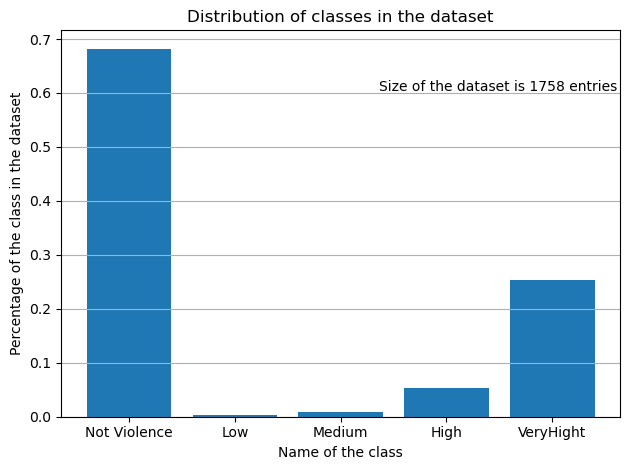

In [60]:
df_final,train_data, test_data, train_target, test_target = DataProcess.division(df_final)

In [61]:
DataProcess.export_vect()

In [62]:
print(train_data.shape)

(1230, 6545)


In [63]:
train_target.info()
print(train_target.unique())

<class 'pandas.core.series.Series'>
Index: 1230 entries, 1392 to 1433
Series name: Classe de Violência
Non-Null Count  Dtype 
--------------  ----- 
1230 non-null   object
dtypes: object(1)
memory usage: 19.2+ KB
['Not Violence' 'VeryHight' 'High' 'Low' 'Medium']


## Testando Modelos de Classificação

### Modelo dummy

In [64]:
model=ModelProcessing.dummy_model(train_data,train_target)

['fit_time', 'score_time', 'test_accuracy', 'test_f1_weighted', 'test_precision_weighted', 'test_recall_weighted']
[0.0011711597442626953, 0.008222866058349609, 0.6821138211382114, 0.46528190891665017, 0.6821138211382114, 0.5532089385532238]


/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being

          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.53  0.53
ROC AUC    0.80  0.80


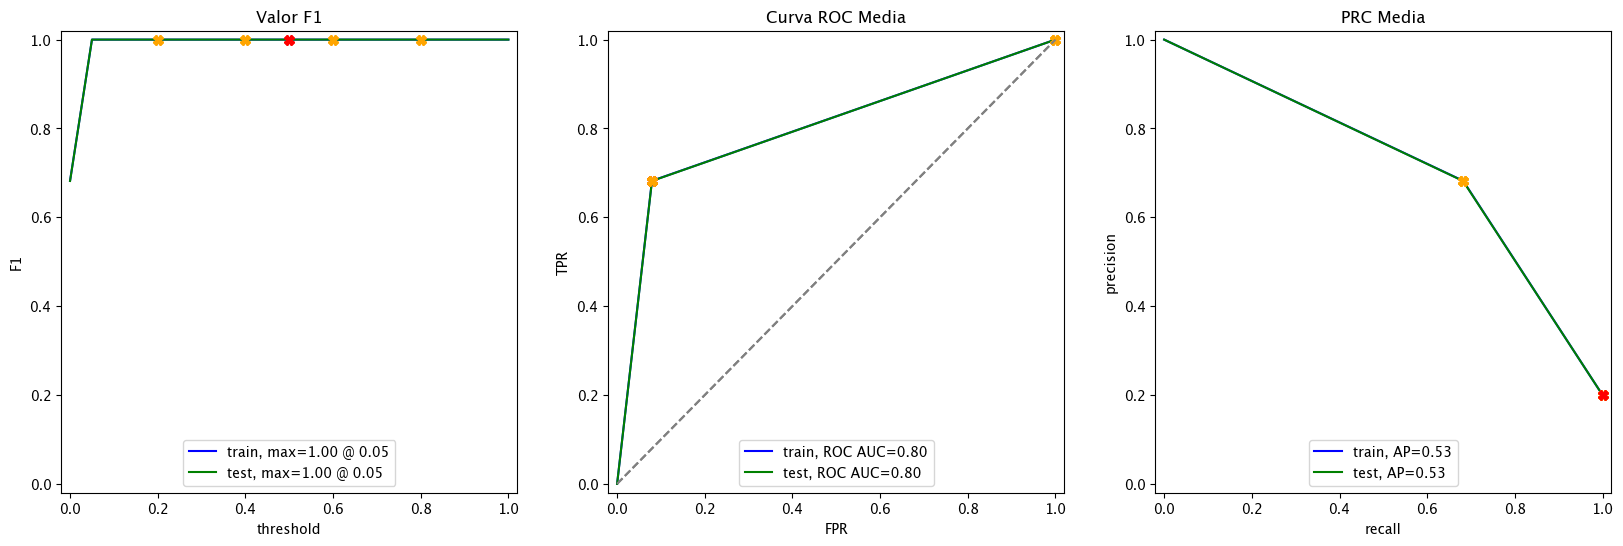

In [12]:
MetricsProcessing().evaluate_model(model,train_data.toarray(),train_target,test_data.toarray(),test_target)

### AdaBoost sem sampling

In [72]:
best_model=ModelProcessing.adaboost_model(train_data,train_target)

  0%|          | 0/99 [00:00<?, ?it/s]/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarni

best number of estimators: 4
['fit_time', 'score_time', 'test_accuracy', 'test_f1_weighted', 'test_precision_weighted', 'test_recall_weighted']
[0.020705795288085936, 0.004504966735839844, 0.7382113821138212, 0.688366825142011, 0.7382113821138212, 0.6732950909149873]
best recall: 0.7382113821138212
best accuracy: 0.7382113821138212
best f1: 0.6732950909149873
best precision: 0.688366825142011


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.67  0.68
ROC AUC    0.92  0.92


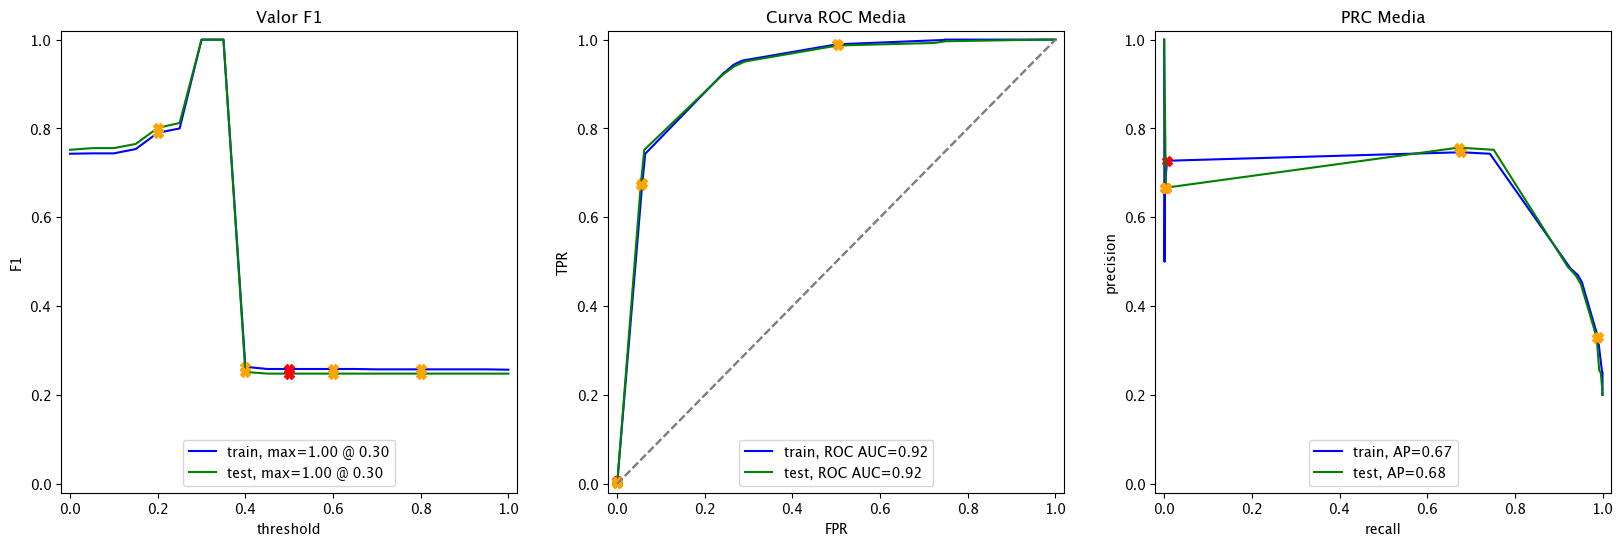

In [14]:
MetricsProcessing().evaluate_model(best_model,train_data.toarray(),train_target,test_data.toarray(),test_target)

### Floresta Aleatoria sem Sampling

In [ ]:
best_model=ModelProcessing.florest_model(train_data,train_target)

  0%|          | 0/49 [00:00<?, ?it/s]/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarni

          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.96  0.88
ROC AUC    0.99  0.96


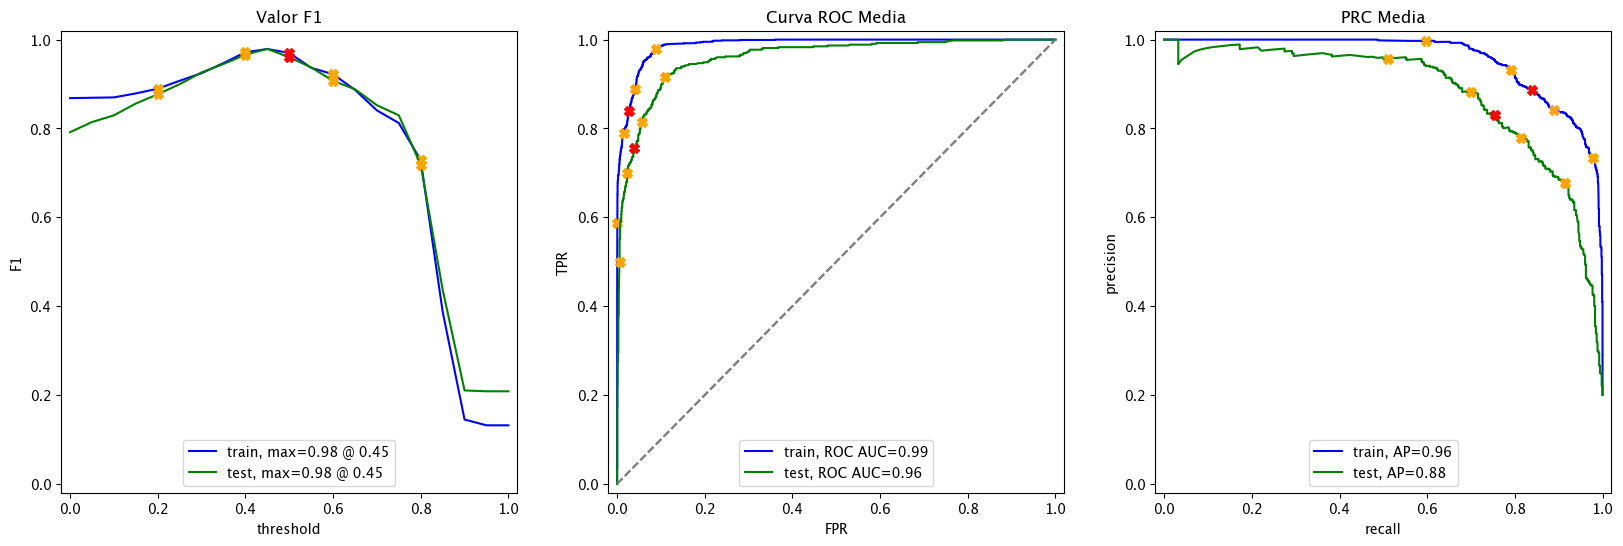

In [16]:
MetricsProcessing().evaluate_model(best_model,train_data.toarray(),train_target,test_data.toarray(),test_target)

### Arvore de decisão sem Sampling

In [17]:
tree_model=ModelProcessing.tree_model(train_data,train_target,test_data,test_target)

  0%|          | 0/99 [00:00<?, ?it/s]

best depth: 73
best recall: 0.8200757575757576
best accuracy: 0.8200757575757576
best f1: 0.8145825710876146
best precision: 0.8092480294455772


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS         1.0  0.67
ROC AUC     1.0  0.87


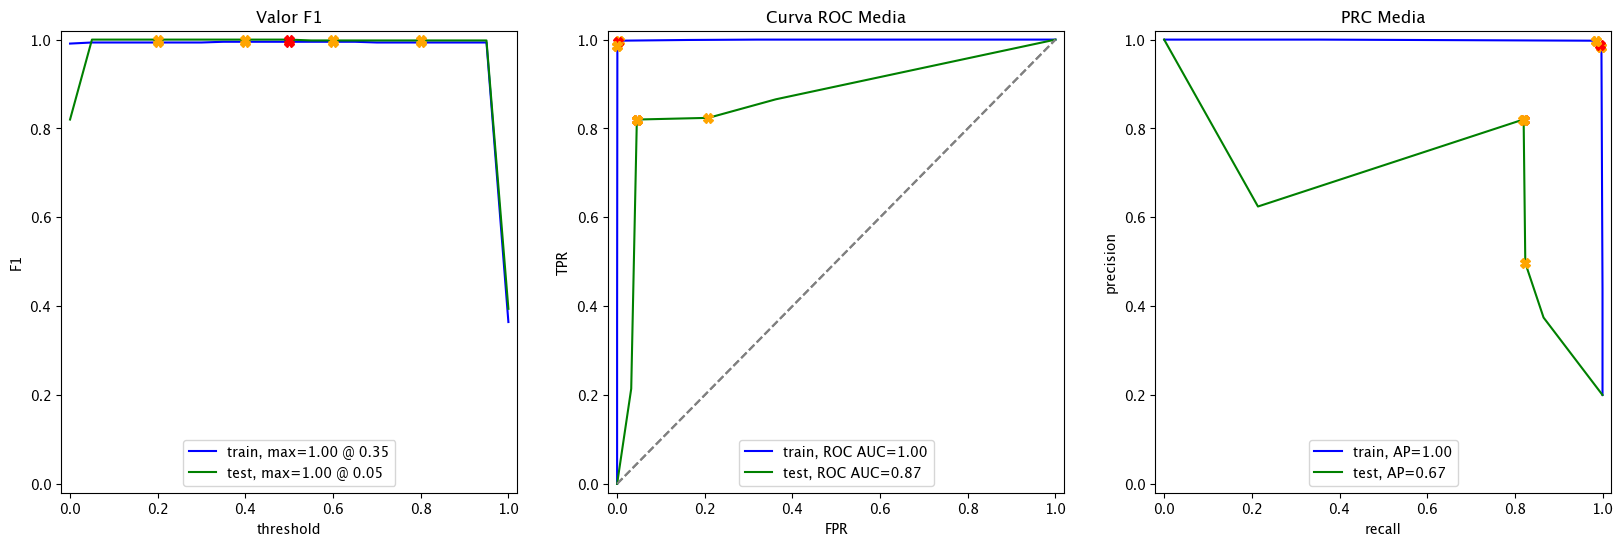

In [18]:
MetricsProcessing().evaluate_model(tree_model,train_data.toarray(),train_target,test_data.toarray(),test_target)

### Naive-Bayes sem sampling

In [19]:
model=ModelProcessing.naivebayes_model(train_data,train_target,test_data,test_target)

best recall: 0.7329545454545454
best accuracy: 0.7329545454545454
best f1: 0.7511976381461676
best precision: 0.7753840488215488


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.91  0.59
ROC AUC    0.97  0.83


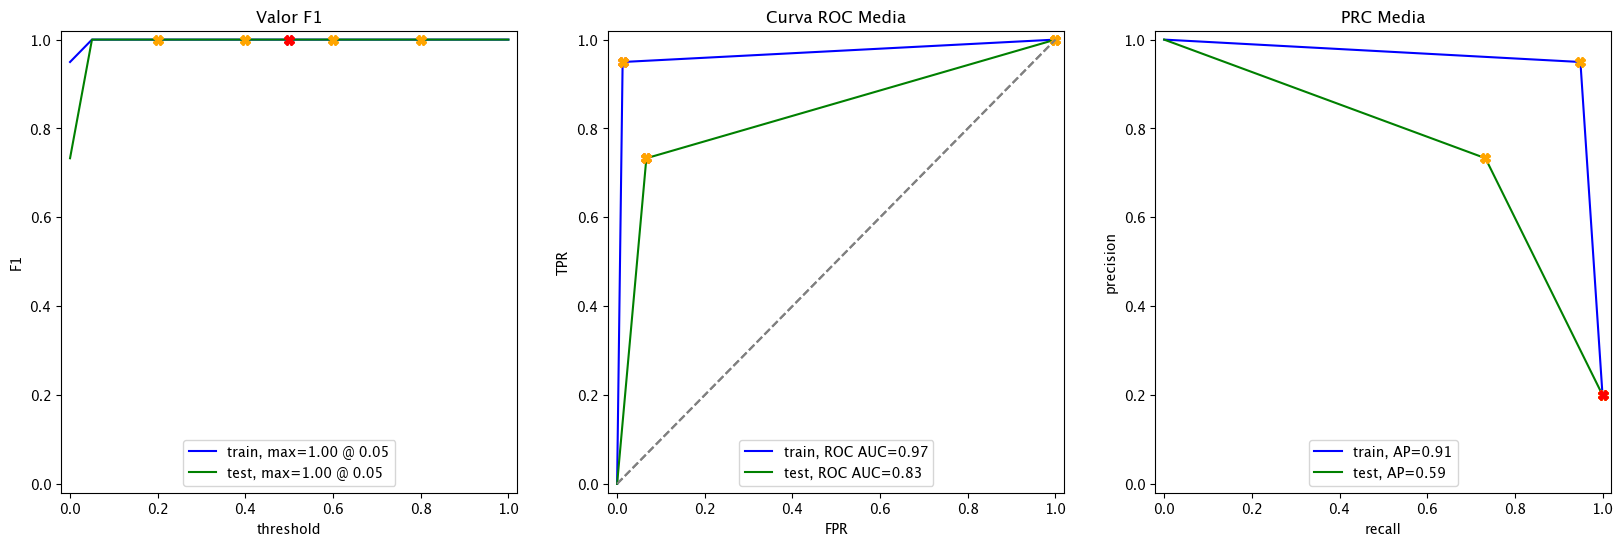

In [20]:
MetricsProcessing().evaluate_model(model,train_data.toarray(),train_target,test_data.toarray(),test_target)

### BERTimbau sem sampling

In [39]:
temp=df_final.copy()
bert_class=BertProcessing()
train_dataset,test_dataset=bert_class.loader(df_final=temp)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1230 [00:00<?, ? examples/s]

/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/528 [00:00<?, ? examples/s]

In [40]:
#features_train, target_train, features_test, target_test=DataProcess.bert_division(df_final=df_final)
print(train_dataset)

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1230
})


In [41]:
model=bert_class.model(train_dataset,test_dataset)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.603622317314148, 'eval_accuracy': 0.8143939393939394, 'eval_precision': 0.8155258589848549, 'eval_recall': 0.8143939393939394, 'eval_f1': 0.7989578496576057, 'eval_runtime': 1.229, 'eval_samples_per_second': 429.603, 'eval_steps_per_second': 53.7, 'epoch': 1.0}


  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.4331469237804413, 'eval_accuracy': 0.8787878787878788, 'eval_precision': 0.8265236929813553, 'eval_recall': 0.8787878787878788, 'eval_f1': 0.8509436385673067, 'eval_runtime': 1.2474, 'eval_samples_per_second': 423.271, 'eval_steps_per_second': 52.909, 'epoch': 2.0}


  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.4676324129104614, 'eval_accuracy': 0.8787878787878788, 'eval_precision': 0.8551829268292683, 'eval_recall': 0.8787878787878788, 'eval_f1': 0.8638561541339319, 'eval_runtime': 1.2972, 'eval_samples_per_second': 407.018, 'eval_steps_per_second': 50.877, 'epoch': 3.0}
{'train_runtime': 60.7572, 'train_samples_per_second': 60.734, 'train_steps_per_second': 7.604, 'train_loss': 0.3987106059020732, 'epoch': 3.0}


/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.86  0.79
ROC AUC    0.95  0.92


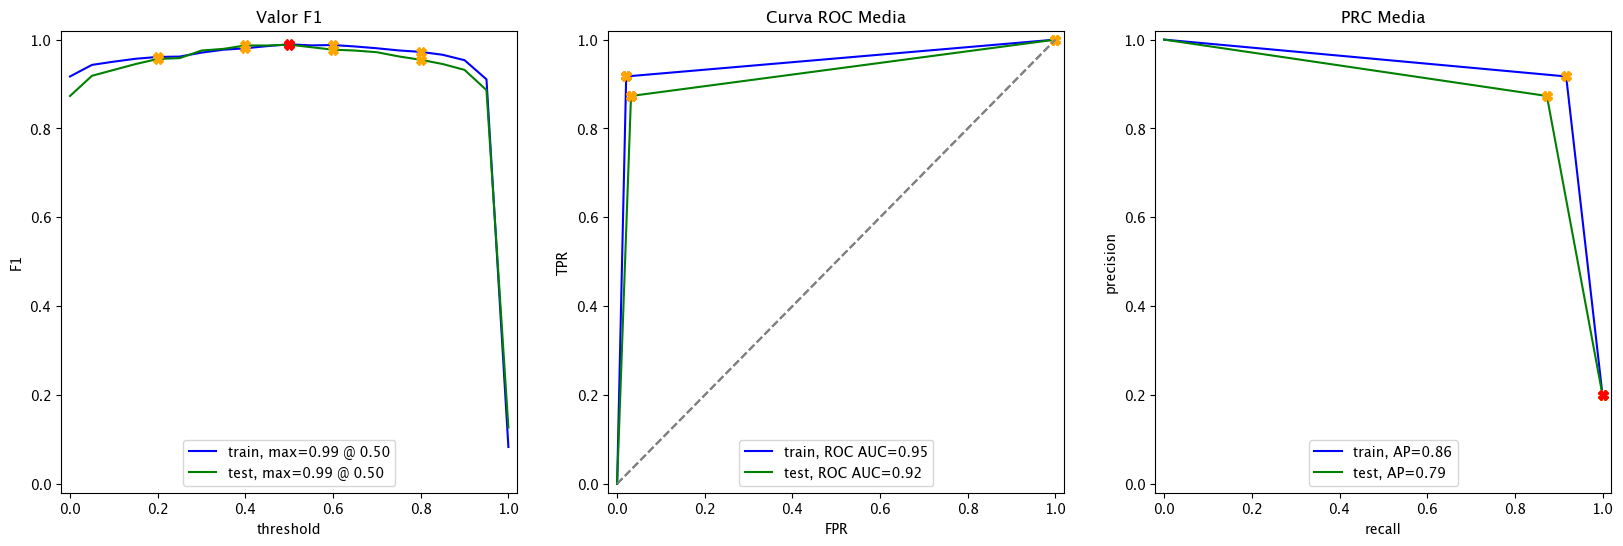

In [42]:
bert_class.evaluate(model,train_dataset,test_dataset)

In [43]:
df_sampled,garbage=train_test_split(temp.drop_duplicates().reset_index(), test_size=0.3, random_state=12345,shuffle=True,stratify=df_final['Classe de Violência'])

In [44]:
prediction=DataProcess.convert_label(bert_class.predict(model,garbage['text'])[:]['label'])

In [27]:
temp2=test_target.copy()
recall=recall_score(DataProcess.numerical_target(temp2),prediction,average='weighted')
acc=accuracy_score(temp2,prediction)
f1=f1_score(temp2,prediction,average='weighted')
precision=precision_score(temp2,prediction,average='weighted',zero_division=0)
print('best recall:',recall)
print('best accuracy:',acc)
print('best f1:',f1)
print('best precision:',precision)

best recall: 0.875
best accuracy: 0.875
best f1: 0.8588888960577373
best precision: 0.8492262167428465


## Sampling os dados

In [28]:
features_sampled,target_sampled=DataProcess.upsampled_division(df_final)

In [29]:
test_target

941     Not Violence
1053    Not Violence
21      Not Violence
1372       VeryHight
1614    Not Violence
            ...     
1386            High
1563    Not Violence
855        VeryHight
394        VeryHight
892        VeryHight
Name: Classe de Violência, Length: 528, dtype: object

### AdaBoost com sampling

In [30]:
best_model=ModelProcessing.adaboost_model(features_sampled,target_sampled,test_data,test_target)

  0%|          | 0/99 [00:00<?, ?it/s]

best number of estimators: 5
best recall: 0.017045454545454544
best accuracy: 0.017045454545454544
best f1: 0.016038288482548443
best precision: 0.1757664400080837


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.34  0.33
ROC AUC    0.66  0.64


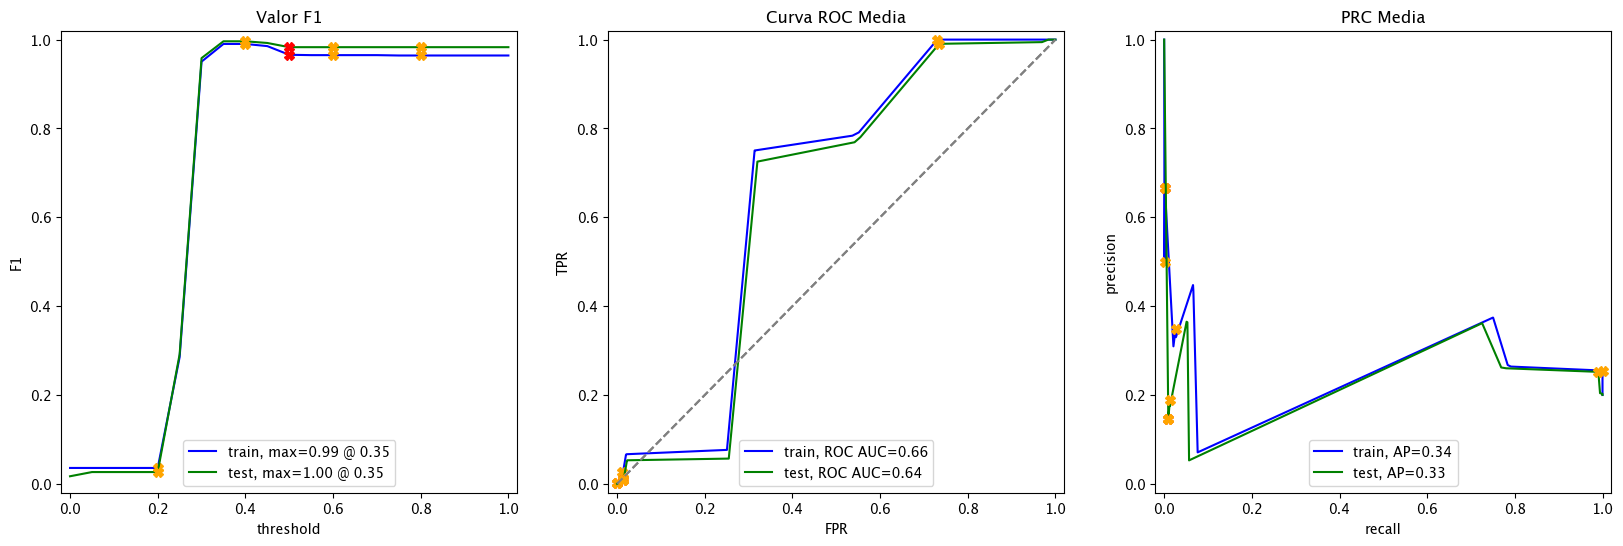

In [31]:
MetricsProcessing().evaluate_model(best_model,train_data.toarray(),train_target,test_data.toarray(),test_target)

### Floresta Aleatoria com Sampling

In [32]:
best_model=ModelProcessing.florest_model(features_sampled,target_sampled,test_data,test_target)

  0%|          | 0/49 [00:00<?, ?it/s]

best depth: 29
best size: 21
best recall: 0.7632575757575758
best accuracy: 0.7632575757575758
best f1: 0.7237333848128602
best precision: 0.7937946306755943


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.90  0.81
ROC AUC    0.97  0.93


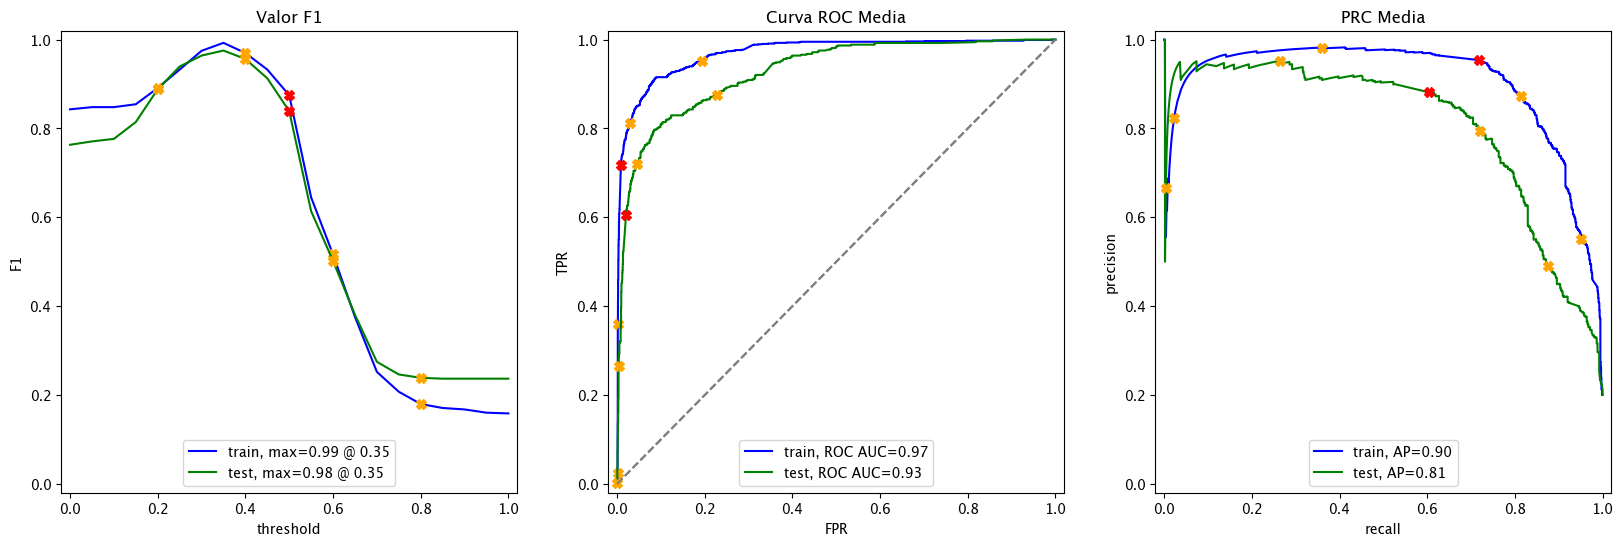

In [33]:
MetricsProcessing().evaluate_model(best_model,train_data.toarray(),train_target,test_data.toarray(),test_target)

### Arvore de decisão com Sampling

In [34]:
best_model=ModelProcessing.tree_model(features_sampled,target_sampled,test_data,test_target)

tree_model_upsampling=best_model

  0%|          | 0/99 [00:00<?, ?it/s]

best depth: 38
best recall: 0.7954545454545454
best accuracy: 0.7954545454545454
best f1: 0.788440383620773
best precision: 0.8106343557476484


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.97  0.68
ROC AUC    0.99  0.88


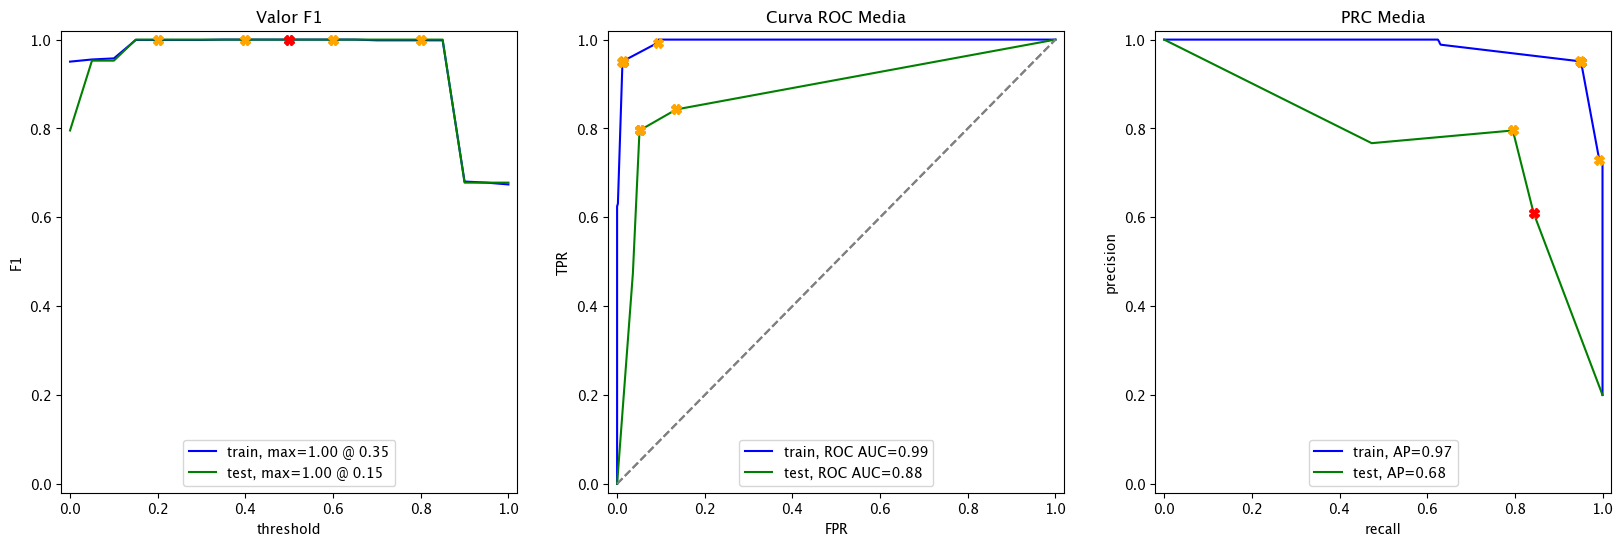

In [35]:
MetricsProcessing().evaluate_model(best_model,train_data.toarray(),train_target,test_data.toarray(),test_target)

### Naive-Bayes com sampling

In [36]:
model=ModelProcessing.naivebayes_model(features_sampled,target_sampled,test_data,test_target)

best recall: 0.7329545454545454
best accuracy: 0.7329545454545454
best f1: 0.7511976381461676
best precision: 0.7753840488215488


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.91  0.59
ROC AUC    0.97  0.83


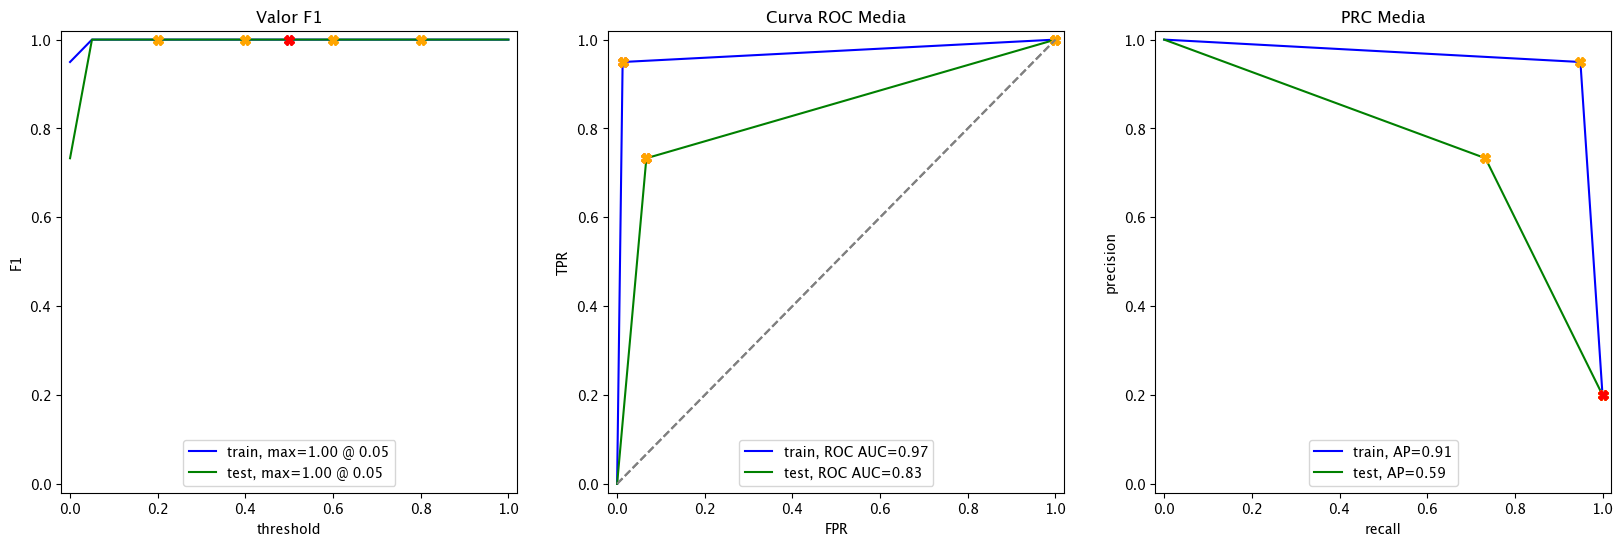

In [37]:
MetricsProcessing().evaluate_model(model,train_data.toarray(),train_target,test_data.toarray(),test_target)

## Analise da complexidade dos dados sem sampling vs com sampling usando PCA

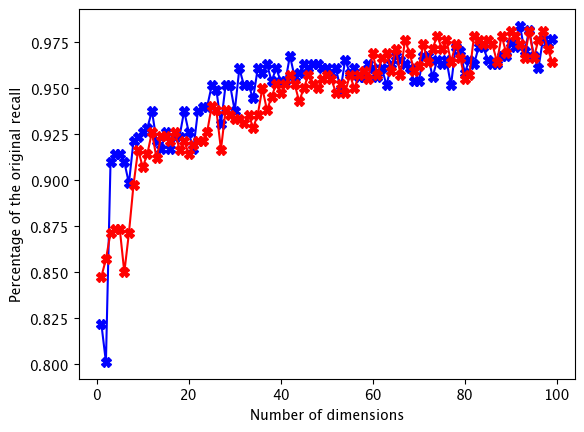

In [38]:
MetricsProcessing.pca_evaluator(model=tree_model,model2=tree_model_upsampling,test_data=test_data,test_target=test_target,n_components=100)

# Conclusões

Por enquanto o melhor modelo entre eles, sem contar o XGBoost, parece ser a arvore de decisão.

Parece valer a pena testar a vetorização com por NILC quando testarmos regressão.

Normalização da uma pequena melhora em alguns dos modelos, mas talvez seja por coincidencia (a seed ser boa para aquele novo formato de matriz especifica)